# Step 1: Data Import

In [1]:
# Library imports 
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing

In [2]:
#importing data
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Step 2: EDA

## 2.1: Filtering out single value columns

In [3]:
#remove single value column and filter out the column for 8th month
#remove night pack user data and fb data
print("Original data set size --> " + str(telecom.shape))
tmp1 = telecom.columns
cnt = telecom.shape[0]
flist = []
#flist2 = []
for i in tmp1:
    tmp2 = telecom[i].nunique()
    #if(tmp2 == 2 and i[-1] != '9'):
     #   flist2 = flist2 + [i]
        
    if (tmp2<2):
        flist = flist + [i]
    elif(i[-1] == '8'):
        flist = flist + [i]
flist =  flist + ['fb_user_6','fb_user_7','night_pck_user_6','night_pck_user_7']
telecom.drop(columns = flist, inplace= True)
telecom.set_index('mobile_number', inplace= True)
print("Data set post removal of single value attributes --> " + str( telecom.shape))

Original data set size --> (99999, 226)
Data set post removal of single value attributes --> (99999, 154)


## 2.2: Null value check 

In [4]:
# Null value check for the first iteration
print("Data set before null check --> " + str(telecom.shape))
is_null_vec = telecom.isnull().sum()*100/telecom.shape[0]
rem_rows_col_list = is_null_vec[np.logical_and(is_null_vec < 5, is_null_vec > 0)].index.tolist()
print()
print("List of attributes containing less than 5% null values --> " + str(rem_rows_col_list))
print()
print()
#telecom.dropna(subset=rem_rows_col_list, inplace = True)
print("Data set after removing the rows of columns having less than 5% null  values --> " + str(telecom.shape))
print("Again checking the null value count in the remaining set")

#null value check for the second iteration.Since removal of the sub set may leads to change in the null % 
#for other columns as well.Hence re computing the null value%
is_null_vec = telecom.isnull().sum()*100/telecom.shape[0]
rem_rows_col_list = is_null_vec[np.logical_and(is_null_vec < 5, is_null_vec > 0)].index.tolist()
print("List of attributes containing less than 5% null values --> " + str(rem_rows_col_list))
print()
print()
#telecom.dropna(subset=rem_rows_col_list, inplace = True)
print("Data set after removing the rows of columns having less than 5% null  values --> " + str(telecom.shape))
print("Again checking the null value count in the remaining set")

#Null value check for the third iteration.
#confirming that no more columns contain less than 5% null values
is_null_vec = telecom.isnull().sum()*100/telecom.shape[0]
rem_rows_col_list = is_null_vec[np.logical_and(is_null_vec < 5, is_null_vec > 0)].index.tolist()
print("List of attributes containing less than 5% null values --> " + str(rem_rows_col_list))

Data set before null check --> (99999, 154)

List of attributes containing less than 5% null values --> ['onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6', 'og_others_7', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_mou_6', 'std_ic_mou_7', 'spl_ic_mou_6', 'spl_ic

## 2.3: Checking for derived columns or similar columns

In [5]:
#Analysing the incoming call behaviour

colList = telecom.columns
collist = [x for x in colList if ("ic") in x and x[-1] == '6']
print("Columns related to the data pertaining to 6th month --> ")
print( str(collist))
print()
ic =  pd.DataFrame()
ic =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',  'loc_ic_t2f_mou_6']].sum(axis = 1))
ic['actSum'] = telecom.loc[:,'loc_ic_mou_6']
tmp = pd.DataFrame(round(ic.loc[:,'CalSum'] - ic.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (loc_ic_mou_6) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

ic =  pd.DataFrame()
ic =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,['std_ic_t2t_mou_6', 'std_ic_t2m_mou_6',  'std_ic_t2f_mou_6']].sum(axis = 1))
ic['actSum'] = telecom.loc[:,'std_ic_mou_6']
tmp = pd.DataFrame(round(ic.loc[:,'CalSum'] - ic.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (std_ic_mou_6) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

ic =  pd.DataFrame()
ic =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,[ 'loc_ic_mou_6', 'spl_ic_mou_6','isd_ic_mou_6', 'ic_others_6','std_ic_mou_6']].sum(axis = 1))
ic['actSum'] = telecom.loc[:,'total_ic_mou_6']
tmp = pd.DataFrame(round(ic.loc[:,'CalSum'] - ic.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (total_ic_mou_6) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

#from this we observed that these three columns are extra
#loc_ic_mou_6
#std_ic_mou_6
#total_ic_mou_6
lists = ['loc_ic_mou_6','std_ic_mou_6','total_ic_mou_6']

#lists = ['loc_ic_mou_6','std_ic_mou_6','total_ic_mou_6','loc_ic_mou_7','std_ic_mou_7','total_ic_mou_7']
#lists = ['loc_ic_mou_6','std_ic_mou_6','total_ic_mou_6','loc_ic_mou_7','std_ic_mou_7','total_ic_mou_7','loc_ic_mou_8','std_ic_mou_8','total_ic_mou_8']
print("Data set size pre  removal --> "+ str(telecom.shape))
telecom.drop(columns = lists, inplace= True)
print("Data set size post  removal --> "+ str(telecom.shape))

Columns related to the data pertaining to 6th month --> 
['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6']

Possible difference between the aggregated sum (loc_ic_mou_6) given with respect to computed sum for incoming MOU --> 
-0.01    52182
 0.00    27997
-0.02    15883
Name: 0, dtype: int64


Possible difference between the aggregated sum (std_ic_mou_6) given with respect to computed sum for incoming MOU --> 
 0.00    73078
-0.01    21488
-0.02     1496
Name: 0, dtype: int64


Possible difference between the aggregated sum (total_ic_mou_6) given with respect to computed sum for incoming MOU --> 
-0.01    44907
 0.00    44023
-0.02     9976
-0.03     1052
-0.04       41
Name: 0, dtype: int64


Data set size pre  removal --> (99999, 154)
Data set size post  removal --> (99999, 151)


In [6]:
#Analysing the incoming call behaviour

colList = telecom.columns
collist = [x for x in colList if ("ic") in x and x[-1] == '7']
print("Columns related to the data pertaining to 7th month --> ")
print( str(collist))
print()
ic =  pd.DataFrame()
ic =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,['loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7',  'loc_ic_t2f_mou_7']].sum(axis = 1))
ic['actSum'] = telecom.loc[:,'loc_ic_mou_7']
tmp = pd.DataFrame(round(ic.loc[:,'CalSum'] - ic.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (loc_ic_mou_7) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

ic =  pd.DataFrame()
ic =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,['std_ic_t2t_mou_7', 'std_ic_t2m_mou_7',  'std_ic_t2f_mou_7']].sum(axis = 1))
ic['actSum'] = telecom.loc[:,'std_ic_mou_7']
tmp = pd.DataFrame(round(ic.loc[:,'CalSum'] - ic.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (std_ic_mou_7) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

ic =  pd.DataFrame()
ic =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,[ 'loc_ic_mou_7', 'spl_ic_mou_7','isd_ic_mou_7', 'ic_others_7','std_ic_mou_7']].sum(axis = 1))
ic['actSum'] = telecom.loc[:,'total_ic_mou_7']
tmp = pd.DataFrame(round(ic.loc[:,'CalSum'] - ic.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (total_ic_mou_7) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

#from this we observed that these three columns are extra
#loc_ic_mou_7
#std_ic_mou_7
#total_ic_mou_7
lists = ['loc_ic_mou_7','std_ic_mou_7','total_ic_mou_7']

print("Data set size pre  removal --> "+ str(telecom.shape))
telecom.drop(columns = lists, inplace= True)
print("Data set size post  removal --> "+ str(telecom.shape))

Columns related to the data pertaining to 7th month --> 
['roam_ic_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7']

Possible difference between the aggregated sum (loc_ic_mou_7) given with respect to computed sum for incoming MOU --> 
-0.01    52826
 0.00    27280
-0.02    16034
Name: 0, dtype: int64


Possible difference between the aggregated sum (std_ic_mou_7) given with respect to computed sum for incoming MOU --> 
 0.00    72851
-0.01    21672
-0.02     1617
Name: 0, dtype: int64


Possible difference between the aggregated sum (total_ic_mou_7) given with respect to computed sum for incoming MOU --> 
 0.00    46050
-0.01    45103
-0.02     8230
-0.03      606
-0.04       10
Name: 0, dtype: int64


Data set size pre  removal --> (99999, 151)
Data set size post  removal --> (99999, 148)


In [7]:
#Analysing the incoming call behaviour

colList = telecom.columns
collist = [x for x in colList if ("og") in x and x[-1] == '6']
print("Columns related to the data pertaining to 6th month --> ")
print( str(collist))
print()
og =  pd.DataFrame()
og =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,['loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',  'loc_og_t2f_mou_6']].sum(axis = 1))
og['actSum'] = telecom.loc[:,'loc_og_mou_6']
tmp = pd.DataFrame(round(og.loc[:,'CalSum'] - og.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (loc_og_mou_6) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

og =  pd.DataFrame()
og =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,['std_og_t2t_mou_6', 'std_og_t2m_mou_6',  'std_og_t2f_mou_6']].sum(axis = 1))
og['actSum'] = telecom.loc[:,'std_og_mou_6']
tmp = pd.DataFrame(round(og.loc[:,'CalSum'] - og.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (std_og_mou_6) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

og =  pd.DataFrame()
og =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,[ 'loc_og_mou_6', 'spl_og_mou_6','isd_og_mou_6', 'og_others_6','std_og_mou_6']].sum(axis = 1))
og['actSum'] = telecom.loc[:,'total_og_mou_6']
tmp = pd.DataFrame(round(og.loc[:,'CalSum'] - og.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (total_og_mou_6) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

#from this we observed that these three columns are extra
#loc_og_mou_6
#std_og_mou_6
#total_og_mou_6
lists = ['loc_og_mou_6','std_og_mou_6','total_og_mou_6']

print("Data set size pre  removal --> "+ str(telecom.shape))
telecom.drop(columns = lists, inplace= True)
print("Data set size post  removal --> "+ str(telecom.shape))

Columns related to the data pertaining to 6th month --> 
['roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'total_og_mou_6']

Possible difference between the aggregated sum (loc_og_mou_6) given with respect to computed sum for incoming MOU --> 
-0.01    49558
 0.00    36169
-0.02    10335
Name: 0, dtype: int64


Possible difference between the aggregated sum (std_og_mou_6) given with respect to computed sum for incoming MOU --> 
 0.00    70982
-0.01    24097
-0.02      983
Name: 0, dtype: int64


Possible difference between the aggregated sum (total_og_mou_6) given with respect to computed sum for incoming MOU --> 
 0.00    44009
-0.01    42639
-0.02    12015
-0.03     1323
-0.04       13
Name: 0, dtype: int64


Data set size pre  removal --> (99999, 148)
Data set size post  removal --> (99999, 145)


In [8]:
#Analysing the incoming call behaviour

colList = telecom.columns
collist = [x for x in colList if ("og") in x and x[-1] == '7']
print("Columns related to the data pertaining to 7th month --> ")
print( str(collist))
print()
og =  pd.DataFrame()
og =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,['loc_og_t2t_mou_7', 'loc_og_t2m_mou_7',  'loc_og_t2f_mou_7']].sum(axis = 1))
og['actSum'] = telecom.loc[:,'loc_og_mou_7']
tmp = pd.DataFrame(round(og.loc[:,'CalSum'] - og.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (loc_og_mou_7) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

og =  pd.DataFrame()
og =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,['std_og_t2t_mou_7', 'std_og_t2m_mou_7',  'std_og_t2f_mou_7']].sum(axis = 1))
og['actSum'] = telecom.loc[:,'std_og_mou_7']
tmp = pd.DataFrame(round(og.loc[:,'CalSum'] - og.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (std_og_mou_7) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

og =  pd.DataFrame()
og =pd.DataFrame(columns =['CalSum'], data =  telecom.loc[:,[ 'loc_og_mou_7', 'spl_og_mou_7','isd_og_mou_7', 'og_others_7','std_og_mou_7']].sum(axis = 1))
og['actSum'] = telecom.loc[:,'total_og_mou_7']
tmp = pd.DataFrame(round(og.loc[:,'CalSum'] - og.loc[:,'actSum'], 2))
print("Possible difference between the aggregated sum (total_og_mou_7) given with respect to computed sum for incoming MOU --> " )
print(tmp[0].value_counts())
print()
print()

#from this we observed that these three columns are extra
#loc_og_mou_7
#std_og_mou_7
#total_og_mou_7
lists = ['loc_og_mou_7','std_og_mou_7','total_og_mou_7']

print("Data set size pre  removal --> "+ str(telecom.shape))
telecom.drop(columns = lists, inplace= True)
print("Data set size post  removal --> "+ str(telecom.shape))

Columns related to the data pertaining to 7th month --> 
['roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7', 'total_og_mou_7']

Possible difference between the aggregated sum (loc_og_mou_7) given with respect to computed sum for incoming MOU --> 
-0.01    49847
 0.00    35888
-0.02    10405
Name: 0, dtype: int64


Possible difference between the aggregated sum (std_og_mou_7) given with respect to computed sum for incoming MOU --> 
 0.00    71202
-0.01    24011
-0.02      927
Name: 0, dtype: int64


Possible difference between the aggregated sum (total_og_mou_7) given with respect to computed sum for incoming MOU --> 
 0.00    45381
-0.01    45267
-0.02     9245
-0.03      106
Name: 0, dtype: int64


Data set size pre  removal --> (99999, 145)
Data set size post  removal --> (99999, 142)


In [9]:
telecom.head()

,arpu_6,arpu_7,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_9,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_9,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_9,og_others_6,og_others_7,og_others_9,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_9,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_9,std_ic_mou_9,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_9,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_9,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
mobile_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7000842753,197.385,214.816,21.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,6,362,252,0,252,252,0,6/21/2014,7/16/2014,9/28/2014,252,252,0,6/21/2014,7/16/2014,NaN,1.0,1.0,NaN,252.0,252.0,NaN,0.0,0.0,NaN,1.0,1.0,NaN,252.0,252.0,NaN,30.13,1.32,0.0,83.57,150.76,0.00,212.17,212.17,NaN,212.17,212.17,NaN,NaN,0,0,0,0,0,0,1,1,0,0,0,0,NaN,968,30.4,0.0,101.20,3.58
7001865778,34.047,355.074,86.285,24.11,78.68,18.34,15.74,99.84,53.76,0.0,0.00,0.00,0.0,0.00,0.00,23.88,74.56,18.34,11.51,75.94,53.76,0.00,0.00,0.00,0.0,2.91,0.00,72.11,0.23,4.11,0.00,0.00,0.46,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,4.68,23.43,0.00,0.00,0.0,0.0,72.11,1.61,29.91,116.09,17.48,65.38,56.93,0.00,8.93,0.00,173.03,0.00,0.00,0.00,5.90,0.00,15.01,0.00,0.00,0.00,15.01,188.04,0.00,0.0,0.00,1.83,0.00,0.00,0.00,0.00,0.00,4,9,5,74,384,121,44,154,50,6/29/2014,7/31/2014,9/30/2014,44,23,0,NaN,7/25/2014,NaN,NaN,1.0,NaN,NaN,154.0,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,154.0,NaN,0.00,108.07,0.0,0.00,0.00,0.00,NaN,0.00,NaN,NaN,28.61,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1006,0.0,0.0,0.00,0.00
7001625959,167.690,189.058,290.714,11.54,55.24,74.81,143.33,220.59,118.91,0.0,0.00,38.49,0.0,0.00,70.94,7.19,28.74,14.39,29.34,16.86,28.16,24.11,21.79,22.24,0.0,135.54,0.48,64.81,4.34,26.49,8.76,41.81,67.41,9.28,1.48,14.76,0.0,18.04,0.0,0.0,0.0,46.56,236.84,42.08,0.45,0.0,0.0,124.94,115.69,71.11,148.23,14.38,15.44,38.98,99.48,122.29,158.19,345.41,72.41,71.29,49.44,45.18,177.01,118.18,21.73,58.34,3.86,171.49,517.74,0.21,0.0,0.45,0.

## 2.5: Outliers detection

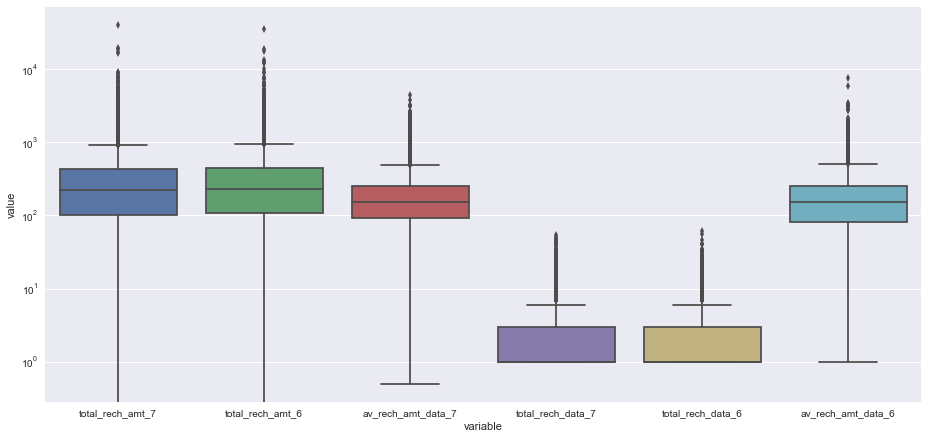

In [10]:
#box plot for outlier analysis
# this has been done on the attributes required for High value customer calculation
import matplotlib.pyplot as plt
import seaborn as sns
#plt.figure(size =(10,10))

lists = ['total_rech_amt_7','total_rech_amt_6','av_rech_amt_data_7','total_rech_data_7','total_rech_data_6','av_rech_amt_data_6']
df = pd.DataFrame(data = telecom[lists], columns = lists)
sns.set(rc={'figure.figsize':(15.7,7.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.yscale('log')
plt.show()

In [11]:
print("Fetching the minimum and maximum value for the given set of attributes")
print("Minimum --> ")
print(telecom[lists].min())
print()
print("Maximum --> ")
print()
print(telecom[lists].max())

# K-sigma echnique for outlier detection
# the data set obatained after the 3rd standard deviation from the attributes have been removed
# Above 3rd std deviation
outlierDetectionlists = lists
#print(outlierDetectionlists)
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

telecom[outlierDetectionlists] = telecom[outlierDetectionlists].apply(cap_outliers, axis=0)
print()
print()
print("Fetching the minimum and maximum value post outlier detection and removal ...")    
print()
print("Minimum --> ")
print(telecom[outlierDetectionlists].min())
print()
print("Maximum --> ")
print()
print(telecom[outlierDetectionlists].max())

Fetching the minimum and maximum value for the given set of attributes
Minimum --> 
total_rech_amt_7      0.0
total_rech_amt_6      0.0
av_rech_amt_data_7    0.5
total_rech_data_7     1.0
total_rech_data_6     1.0
av_rech_amt_data_6    1.0
dtype: float64

Maximum --> 

total_rech_amt_7      40335.0
total_rech_amt_6      35190.0
av_rech_amt_data_7     4365.0
total_rech_data_7        54.0
total_rech_data_6        61.0
av_rech_amt_data_6     7546.0
dtype: float64


Fetching the minimum and maximum value post outlier detection and removal ...

Minimum --> 
total_rech_amt_7      0.0
total_rech_amt_6      0.0
av_rech_amt_data_7    0.5
total_rech_data_7     1.0
total_rech_data_6     1.0
av_rech_amt_data_6    1.0
dtype: float64

Maximum --> 

total_rech_amt_7      1547.305681
total_rech_amt_6      1521.573719
av_rech_amt_data_7     791.354963
total_rech_data_7       11.761199
total_rech_data_6       10.831185
av_rech_amt_data_6     770.539937
dtype: float64


# Step 3: Filtering High value Customers

In [12]:
#Calculating high value customers
df = pd.DataFrame()

#Total data recharge amount for 6th month
df['data_6'] = telecom['av_rech_amt_data_6']*telecom['total_rech_data_6']

#Total data recharge amount for 7th month
df['data_7'] = telecom['av_rech_amt_data_7']*telecom['total_rech_data_7']

#Total recharge amount for 6th month
df['rchg_6'] = telecom['total_rech_amt_6']

#Total recharge amount for 7th month
df['rchg_7'] = telecom['total_rech_amt_7']

#Total data + recharge amount for 6th month
df['amount_6'] = df.loc[:, ['data_6','rchg_6']].sum(axis=1)

#Total data + recharge amount for 7th month
df['amount_7'] = df.loc[:, ['data_7','rchg_7']].sum(axis=1)

#Total average (data + recharge) amount for 6th and 7th month
df['avg_spend'] = df.loc[:,['amount_6','amount_7']].mean(axis=1)

telecom['customer_revenue'] = df['avg_spend']
print("Threshold value is considered as 70th percentile of the avg('customer_revenue') for high value customers")
print("The given threshold is --> " + str(telecom['customer_revenue'].quantile(0.7)))
      
#filter out HVC
print()
print()
print("Dataset size pre filtering -->" + str(telecom.shape))
telecom = telecom[telecom['customer_revenue']>=504]
print("Dataset size post filtering -->" + str(telecom.shape))  

Threshold value is considered as 70th percentile of the avg('customer_revenue') for high value customers
The given threshold is --> 477.79999999999563


Dataset size pre filtering -->(99999, 143)
Dataset size post filtering -->(28240, 143)


# Step 4: Defining class as churned - 1, not churned - 0 for dataset 

In [13]:
#adding the column churn based on the data for 9th month
telecom['total_9month'] = telecom.loc[:, ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1)
telecom['churn'] = telecom.total_9month.apply(lambda x : 1 if x == 0 else 0)
telecom.drop(columns = ['total_9month'],inplace = True)
telecom.churn.astype(int, inplace = True)
print("Percentage of churn data  " + str(round((telecom['churn'].sum()/telecom.shape[0])*100,2)) + " %")
print("Value count of churn data")
print(telecom.churn.value_counts())

Percentage of churn data  8.16 %
Value count of churn data
0    25937
1     2303
Name: churn, dtype: int64


In [14]:
#remove all the columns pertaining to the 9th month

print("Data set pre removal of 9th month data and date attributes")
print(telecom.shape)
tmp1 = telecom.columns
cnt = telecom.shape[0]
flist = []
for i in tmp1:
    if (i[-1] == '9'):
        flist = flist + [i]       
telecom.drop(columns = flist, inplace = True)

#Removing all the Date columns
print()
print("Data set post removal of 9th month data and date attributes")
print(list(telecom.select_dtypes(include=['object']).columns))
telecom.drop(columns = list(telecom.select_dtypes(include=['object']).columns), axis = 0, inplace = True)
print(telecom.shape)

Data set pre removal of 9th month data and date attributes
(28240, 144)

Data set post removal of 9th month data and date attributes
['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7']
(28240, 89)


In [ ]:
plt.figure(figsize = (200,100))
sns.heatmap(telecom.corr(),annot = True)

# Step 5: Removing class imbalanced state

In [16]:
telecom.churn.value_counts()

0    25937
1     2303
Name: churn, dtype: int64

In [17]:
#removing the unbalance state in the train data set
# Separate majority and minority classes
telecom_majority = telecom[telecom.churn==0]
telecom_minority = telecom[telecom.churn==1]

# Upsample minority class
telecom_minority_upsampled = resample(telecom_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=25139,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
telecom_upsampled = pd.concat([telecom_majority, telecom_minority_upsampled])
 
# Display new class counts
print("Data set size before imputation --> " + str(telecom_upsampled.shape))
print()

print("Value count for the dependent and independent variables in the train data set after imputing--> ")
print(telecom_upsampled.churn.value_counts())
print("Data set size after imputation --> " + str(telecom_upsampled.shape))

Data set size before imputation --> (51076, 89)

Value count for the dependent and independent variables in the train data set after imputing--> 
0    25937
1    25139
Name: churn, dtype: int64
Data set size after imputation --> (51076, 89)


In [18]:
# Splitting the data set into test and train sub set
train, test = train_test_split(telecom_upsampled, train_size=0.7,test_size=0.3,random_state=100)
print("Size of train data set --> " + str(train.shape))
print("Size of test data set --> " + str(test.shape))


Size of train data set --> (35753, 89)
Size of test data set --> (15323, 89)


# Step 6: Data preparation 

## Creating X, Y data sets and Preforming PCA

In [19]:
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)
y_train = train['churn']
X_train = train.drop(['churn'], axis=1)

y_test = test['churn']
X_test = test.drop(['churn'], axis=1)

print("X train dataset size"+ str(X_train.shape))
print("X test dataset size"+ str(X_test.shape))
print("Y train dataset size"+ str(y_train.shape))
print("Y test dataset size"+ str(y_test.shape))

X train dataset size(35753, 88)
X test dataset size(15323, 88)
Y train dataset size(35753,)
Y test dataset size(15323,)


In [20]:
# Scaling transformation

X_scaler = preprocessing.StandardScaler().fit(X_train)
Xtrain=X_scaler.transform(X_train) 

Xtest=X_scaler.transform(X_test)

# PCA
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(Xtrain)

#print(pca.components_)
print(pd.DataFrame(pca.components_).shape)

pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2]})
pcs_df.head()

(88, 88)


,PC1,PC2,PC3
0,-0.023151,0.211035,0.159091
1,-0.004154,0.220172,0.188516
2,-0.100657,0.100996,0.147634
3,-0.093302,0.105203,0.154256
4,-0.097956,0.159847,0.165001


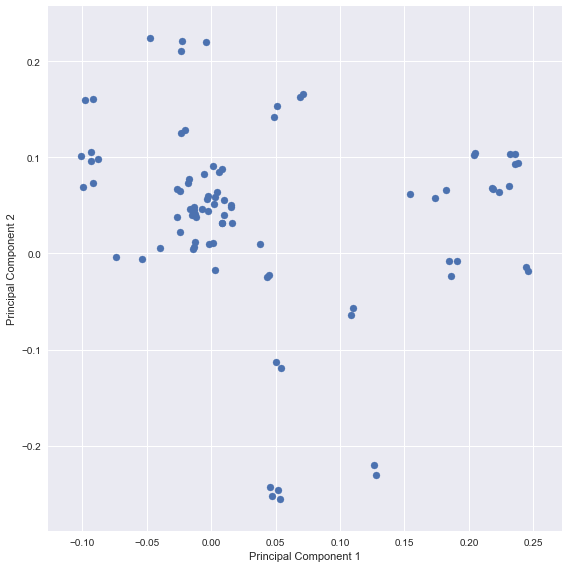

In [21]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i in range(0,pcs_df.shape[0]):
    plt.annotate("", (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

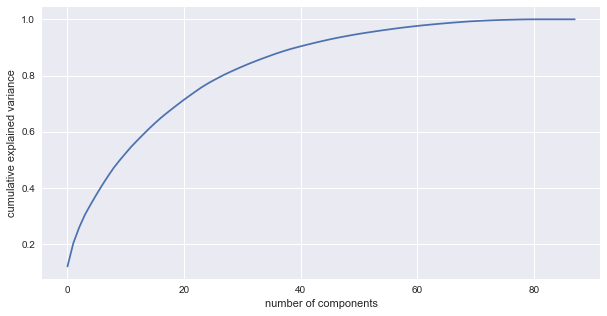

In [22]:
# Data variance with respect to PC count
%matplotlib inline
fig = plt.figure(figsize = (10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [23]:
# Since the graph shows its 80-90 % of its variance with 35-45 PC's, hence we can choose 
# the number of PC's with least collinearity

In [24]:
# PCs = 35
pca_final = IncrementalPCA(n_components=35)
telecom_train_pca = pca_final.fit_transform(X_train)
print(telecom_train_pca.shape)

corrmat = np.corrcoef(telecom_train_pca.transpose())

corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)


(35753, 35)
max corr: 0.0032596996895170624 , min corr:  -0.007022333206031429


In [25]:
# PCs = 45
pca_final = IncrementalPCA(n_components=45)
telecom_train_pca = pca_final.fit_transform(X_train)
print(telecom_train_pca.shape)

corrmat = np.corrcoef(telecom_train_pca.transpose())

corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

(35753, 45)
max corr: 0.051177343342165914 , min corr:  -0.11431467096868227


In [26]:
# PCs = 40
pca_final = IncrementalPCA(n_components=40)
telecom_train_pca = pca_final.fit_transform(X_train)
print(telecom_train_pca.shape)

corrmat = np.corrcoef(telecom_train_pca.transpose())

corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)


(35753, 40)
max corr: 0.001658076958061973 , min corr:  -0.0030040129654344445


In [27]:
telecom_test_pca = pca_final.transform(Xtest)
telecom_test_pca.shape

(15323, 40)

In [28]:
#Scaling and transform
from sklearn import preprocessing
X_scaler = preprocessing.StandardScaler().fit(telecom_train_pca)

X_train_pca =X_scaler.transform(telecom_train_pca) 

X_test_pca=X_scaler.transform(telecom_test_pca)

print(pd.DataFrame(telecom_test_pca).shape)

(15323, 40)


In [29]:
#Training the model on the train data

#X_train_pca = telecom_train_pca
#X_test_pca = telecom_test_pca
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(X_train_pca,y_train)

#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(X_test_pca)[:,1]
#print(X_test_pca.size)
print(y_test.size)
print(pred_probs_test.size)
print("{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test)))

15323
15323
0.75


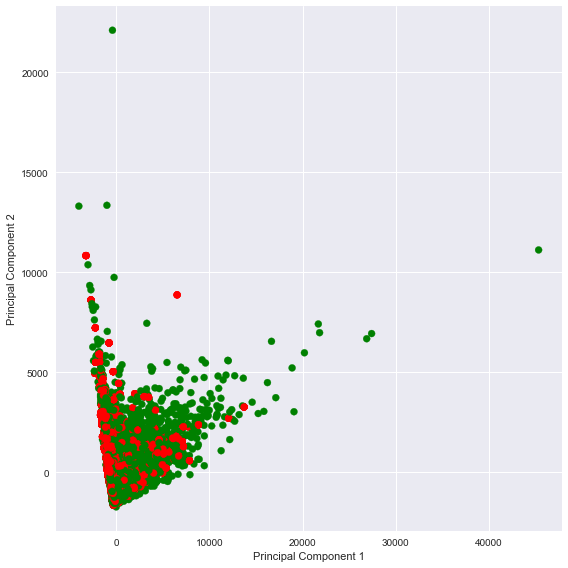

In [30]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(telecom_train_pca[:,0], telecom_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [31]:
y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace = True)

df = pd.DataFrame(pred_probs_test)
df['Churn_Pred'] = df.loc[:,0]

y_test['predicted_values'] = df.Churn_Pred.map( lambda x: 1 if x > 0.66 else 0)
# Let's see the head
y_test.predicted_values.value_counts()

1    8398
0    6925
Name: predicted_values, dtype: int64

In [32]:
print((df['Churn_Pred'].min() + df['Churn_Pred'].max())/2)
print(df['Churn_Pred'].min())
print(df['Churn_Pred'].max())
#print(df.Churn_Pred)

0.658103695141133
0.6459548459431365
0.6702525443391294


In [33]:
# Confusion matrix 
#pred_probs_test
confusion = metrics.confusion_matrix( y_test.churn, y_test.predicted_values )
confusion

array([[4989, 2779],
       [1936, 5619]], dtype=int64)

In [34]:
sensitivityRatio = (confusion[0][0]/(confusion[0][0]+ confusion[1][0]))*100
print(sensitivityRatio)

specificityRatio = (confusion[1][1]/(confusion[1][1]+ confusion[0][1]))*100
print(specificityRatio)

accuracy = (metrics.accuracy_score(y_test.churn, y_test.predicted_values))*100
print(accuracy)

72.04332129963899
66.90878780662062
69.22926319911244


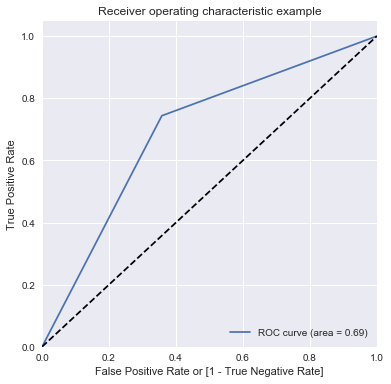

'0.69'

In [35]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds
draw_roc(y_test.churn, y_test.predicted_values)
"{:2.2f}".format(metrics.roc_auc_score(y_test.churn, y_test.predicted_values))

In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Model building

model = SVC(C = 1)
# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)
# metrics
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test['churn'], y_pred))

# precision
print("precision", metrics.precision_score(y_test['churn'], y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test['churn'], y_pred))


accuracy 1.0
precision 1.0
recall 1.0


In [38]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [1, 0.1, 0.01]}
model = LogisticRegression()
scorings = ['accuracy', 'recall', 'precision']
scores = ['accuracy', 'precision', 'recall']

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                       return_train_score=True, n_jobs=-1)    
model_cv.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 0.1, 0.01]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=1)

In [39]:
print(" The highest score is {0} at C = {1}".format(model_cv.best_score_, model_cv.best_params_))                

 The highest score is 0.7072133806953262 at C = {'C': 0.01}


# Decision tree - Business understanding

In [40]:
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
l1 = ['jul_vbc_3g','aug_vbc_3g','sep_vbc_3g','sachet_3g_6','sachet_3g_7','sachet_2g_6','sachet_2g_7','jun_vbc_3g']
X_train.drop(columns = l1, axis=0, inplace= True )
X_test.drop(columns = l1, axis=0, inplace= True )
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test.churn, y_pred_default))

             precision    recall  f1-score   support

          0       0.72      0.64      0.68      7768
          1       0.67      0.74      0.70      7555

avg / total       0.70      0.69      0.69     15323



In [42]:
print("accuracy", metrics.accuracy_score(y_test['churn'], y_pred_default))

accuracy 0.693206291196241


### Plotting Decision trees

In [43]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Putting features
l1 = ['jul_vbc_3g','aug_vbc_3g','sep_vbc_3g','sachet_3g_6','sachet_3g_7','sachet_2g_6','sachet_2g_7','jun_vbc_3g']
df1 = telecom.drop(columns = l1, axis =0 )
features = list(df1.columns[1:])
#features = [x for x in features if x not in l1]

In [46]:
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())